# Lab 7: Implement a Convolutional Neural Network (CNN) with PyTorch

In this lab, we will implement a convolutional neural network using the famous deep learning library, PyTorch. Specifically, we'll build a CNN model and train it to perform the image classification task with datasets such as MNIST and CIFAR-10. You can also see the structure of a typical machine learning training/testing pipeline using PyTorch.

### Import libraries

In [1]:
# Import necessary libraries as usual
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

### Define the model class

In [2]:
in_channel_to_in_features_to_fc = {
    1: 12 * 12 * 64,
    3: 14 * 14 * 64,
}

class ConvNet(nn.Module):
    """Defines a small CNN with two dropout layers"""
    def __init__(self, in_channel: int = 1, out_dim: int = 10):
        super().__init__()

        # The parameters passed to instantiate Conv layers: 
        # (in_channels, out_channels, kernel_size, stride=1, padding=0)
        self.conv1 = nn.Conv2d(in_channel, 32, 3, 1)  # (32 - 3) + 1 = 30
        self.conv2 = nn.Conv2d(32, 64, 3, 1)          # (30 - 3) + 1 = 28

        # Pooling layer (default stride is the kernel size)
        self.pool = nn.MaxPool2d(2)                   # (28 - 2) / 2 + 1 = 14

        # Dropout layers
        self.dropout1 = nn.Dropout(0.25)  # params: (probability to be zeroed)
        self.dropout2 = nn.Dropout(0.5)

        # FC layers
        self.fc1 = nn.Linear(in_channel_to_in_features_to_fc[in_channel], 128)   # params: (in_features, out_features)
        self.fc2 = nn.Linear(128, out_dim)

    def forward(self, x):
        x = self.conv1(x)          # pass through the first conv layer
        x = torch.relu(x)          # applying ReLU nonlinearity
        x = self.conv2(x)          # pass through the second conv layer
        x = torch.relu(x)          # applying ReLU nonlinearity
        x = self.pool(x)           # max pooling -> what's the output shape?
        x = self.dropout1(x)       # Dropout
        x = x.flatten(1)           # flatten before passing through FC layers
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        out = F.log_softmax(x, dim=1)     # apply softmax, followed by logarithm
        return out

### Define train and test functions

In [3]:
def train(args, model, device, data_loader, optimizer, epoch):
    # Set the model to the train mode (affects, e.g., dropout)
    model.train()
    
    num_samples = 0

    # Go through mini-batches of the data using the data loader
    for batch_idx, (data, target) in enumerate(data_loader):
        # Data can either sit on GPU, CPU, or TPU (Colab)
        data, target = data.to(device), target.to(device)
        num_samples += len(data)

        # Zero-out all existing gradients of the model parameters
        optimizer.zero_grad() 

        # Compute the log prediction through the forward propagation
        out = model(data)

        # Compute the loss and perform backpropagation
        loss = F.nll_loss(out, target)
        loss.backward()
        
        # Take a gradient descent step using the optimizer
        optimizer.step()

        # Occasionally print out training statistics
        if batch_idx % args.log_interval == 0:
            print(f'Train Epoch: {epoch} [{num_samples}/' +\
            f'{len(data_loader.dataset)} ({round(100 * num_samples / len(data_loader.dataset))}%)]' +\
            f' Loss: {round(loss.item(), 4)}')
            # Set this to True if you want to terminate the iteration immediately
            if args.dry_run:
                break

In [4]:
def test(model, device, data_loader):
    # Set the model to the train mode (affects, e.g., dropout)
    model.eval()

    test_loss = 0.
    correct = 0
    num_samples = 0

    with torch.no_grad():   # This blocks gradient computation
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            num_samples += len(data)

            # Forward pass
            out = model(data)
            
            # Accumulate the test losses
            test_loss += F.nll_loss(out, target, reduction='sum').item()

            # Get the prediction by taking the argmax over the log prob
            pred = out.argmax(dim=1, keepdim=True)

            # Count corrrectly classified samples
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # Compute the average test loss
    test_loss /= num_samples
    test_acc = 100 * correct/num_samples
    print(f'\nTest set: Average loss: {round(test_loss, 4)}, ' + \
          f'Accuracy: {round(test_acc)}% ({correct}/{num_samples})')
    return test_loss, test_acc

In [9]:
def get_train_loss_and_accuracy(model, device, train_loader):
    train_loss = 0
    train_correct = 0
    model.eval()

    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            train_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            train_correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * train_correct / len(train_loader.dataset)
    return train_loss, train_acc

### Now, define the main function for running training/evaluation

In [6]:
def main(args):
    # Training setup
    use_gpu = args.use_gpu and torch.cuda.is_available()
    device = torch.device("cuda" if use_gpu else "cpu") 

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}

    if use_gpu:
        cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    
    # Define transformation to be applied to data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

    # Get the torchvision dataset
    train_dataset = getattr(datasets, args.dataset)(
        '../data', train=True, download=True, transform=transform
    )
    test_dataset = getattr(datasets, args.dataset)(
        '../data', train=False, download=True, transform=transform
    )

    # Instantiate DataLoader
    train_loader = DataLoader(train_dataset, **train_kwargs)
    test_loader = DataLoader(test_dataset, **test_kwargs)


    # Instantiate the CNN model and move it to the proper processor
    model = ConvNet(args.in_channel, args.out_dim).to(device)

    # Create an optimizer and pass in the model parameters
    optimizer = getattr(optim, args.optimizer)(model.parameters(), lr=args.lr)

    # Define a learning rate schedule
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

    train_losses, test_losses, train_accs, test_accs = [], [], [], []
    epochs = []

    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test_loss, test_acc = test(model, device, test_loader)

        # Store the model performance
        train_loss, train_acc = get_train_loss_and_accuracy(model, device, train_loader)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        epochs.append(epoch)
        
        # Update the learning rate
        scheduler.step()
    
    if args.plot:
        plt.plot(epochs, train_losses, label='Training Loss')
        plt.plot(epochs, test_losses, label="Test Loss")
        plt.legend()
        plt.savefig(f'Loss_lr={args.lr}_batch={args.batch_size}_optimizer={args.optimizer}.png')
        plt.clf()
        plt.plot(epochs, train_accs, label="Training Accuracy")
        plt.plot(epochs, test_accs, label="Test Accuracy")
        plt.legend()
        plt.savefig(f'Accuracy_lr={args.lr}_batch={args.batch_size}_optimizer={args.optimizer}.png')
    if args.save_model:
        torch.save(model.state_dict(), args.dataset + ".pt")
    
    return train_losses, train_accs, test_losses, test_accs


In [7]:
class Args:
    batch_size = 64
    test_batch_size = 1000
    epochs = 14
    lr = 0.001
    gamma = 0.7
    use_gpu = True
    dry_run = False
    seed = 0
    log_interval = 100
    save_model = False
    plot = False
    optimizer = 'Adam'
    dataset = 'MNIST'
    in_channel = 1        # use 3 for 'CIFAR10' and 'CIFAR100'
    out_dim = 10          # use 10 for 'MNIST' and 'CIFAR10', 100 for 'CIFAR100'
  
args = Args()

Train Epoch: 1 [128/60000 (0%)] Loss: 2.3121
Train Epoch: 1 [12928/60000 (22%)] Loss: 0.0932
Train Epoch: 1 [25728/60000 (43%)] Loss: 0.1156
Train Epoch: 1 [38528/60000 (64%)] Loss: 0.1818
Train Epoch: 1 [51328/60000 (86%)] Loss: 0.0405

Test set: Average loss: 0.0552, Accuracy: 98% (9835/10000)
Train Epoch: 2 [128/60000 (0%)] Loss: 0.0683
Train Epoch: 2 [12928/60000 (22%)] Loss: 0.0603
Train Epoch: 2 [25728/60000 (43%)] Loss: 0.0482
Train Epoch: 2 [38528/60000 (64%)] Loss: 0.1673
Train Epoch: 2 [51328/60000 (86%)] Loss: 0.1235

Test set: Average loss: 0.0353, Accuracy: 99% (9882/10000)


([0.05058605658213298, 0.03040926774876813],
 [98.48166666666667, 99.04666666666667],
 [0.05519054183959961, 0.03533651332855225],
 [98.35, 98.82])

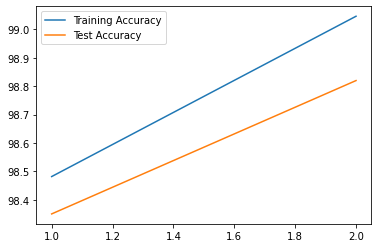

In [10]:
args.gamma = 1.0
args.batch_size = 128
args.epochs = 2
args.dataset = 'MNIST'
args.in_channel = 1
args.out_dim = 10
args.plot = True
main(args)